#**Travel Planner RAG System for Nepal**
**Course:** DSCI 6004 01 - Natural Language Processing

 **By:** Savyata Regmi


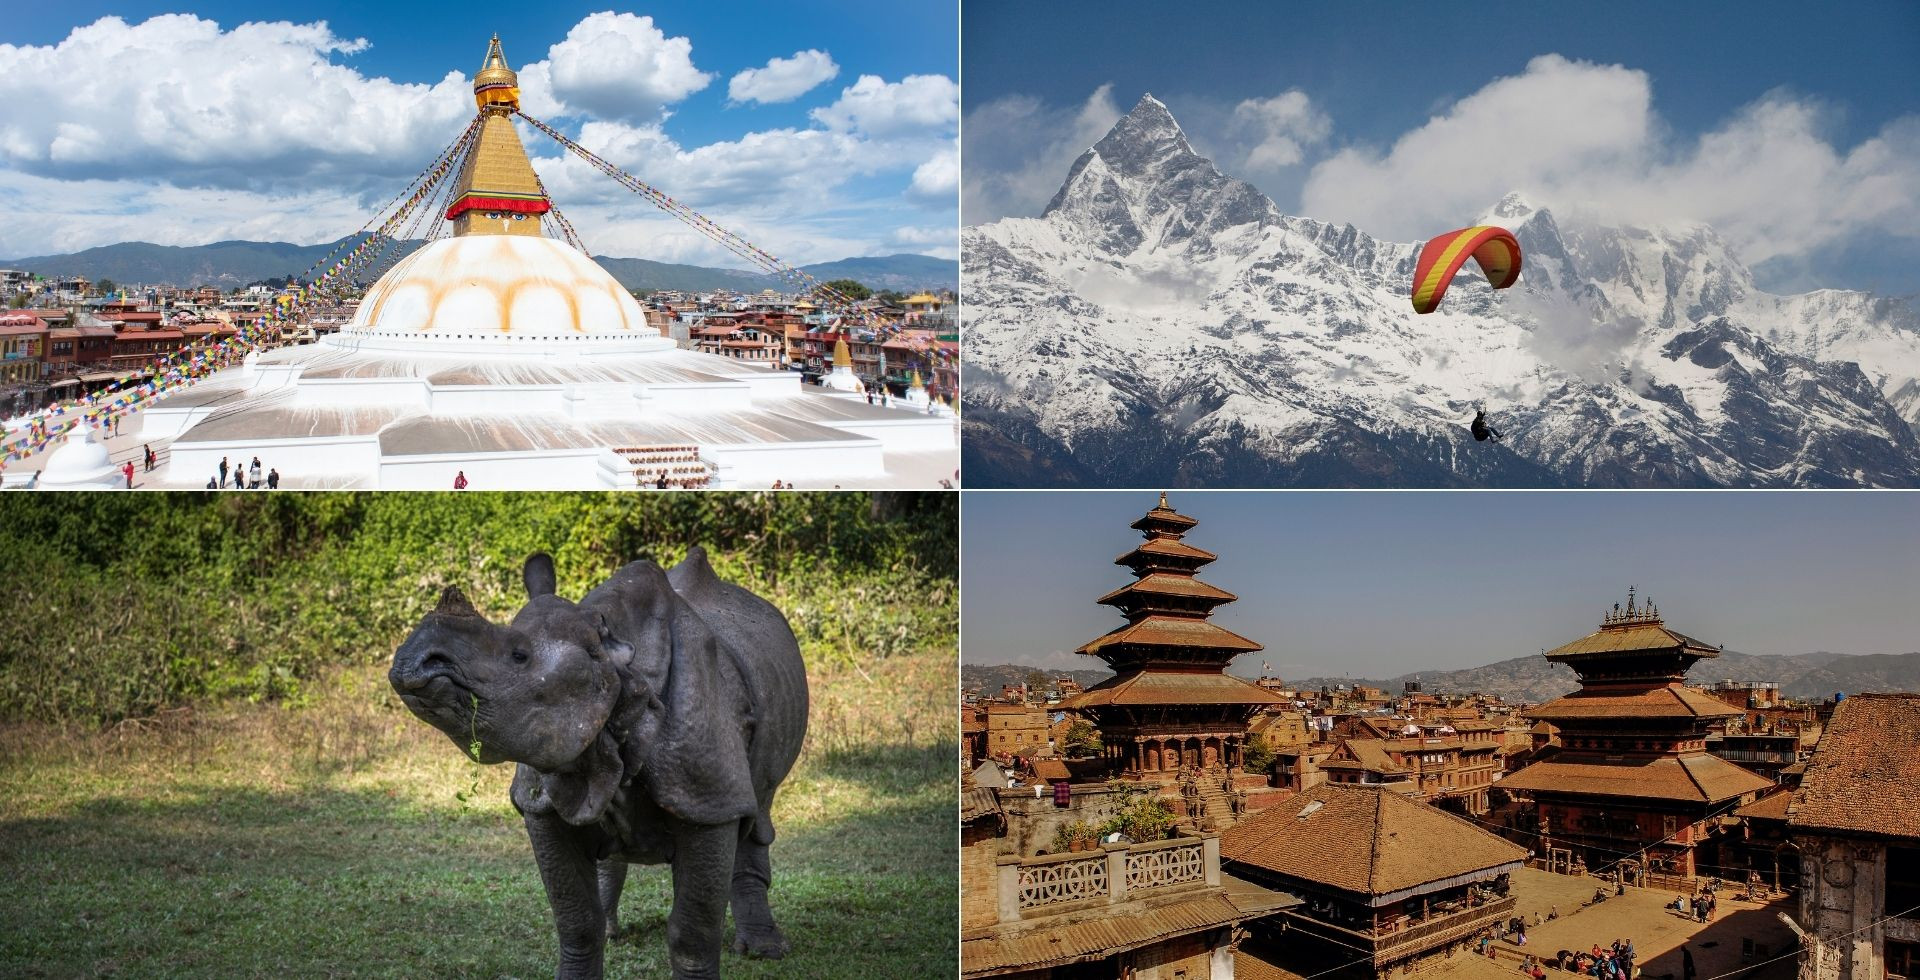


## **Project Overview**

This project implements a Retrieval-Augmented Generation (RAG) system designed to assist tourists planning a trip to Nepal. The system answers domain-specific queries such as must-try foods, festival dates, trekking routes, flight costs, and visa information by retrieving and synthesizing knowledge from curated text files.

### **Objectives**

- Build a structured knowledge base from multiple text sources covering Nepalese travel content
- Chunk and embed the data using semantic embeddings (MiniLM from `sentence-transformers`)
- Create a FAISS index for efficient similarity-based retrieval
- Compare multiple open-source LLMs on their ability to use retrieved context and generate useful answers

### **RAG Architecture Summary**

```plaintext
[.txt files]
    ↓
[Custom Chunking (file-specific)]
    ↓
[MiniLM Embedding: 384-d vectors]
    ↓
[FAISS Index: L2 Similarity]
    ↓
[User Query → MiniLM Vector]
    ↓
[Top k=4 Matching Chunks]
    ↓
[RAG Prompt Generator (per model)]
    ↓
[FLAN-Base / TinyLLaMA / FLAN Large]
    ↓
[Answer Generation]


# RAG Project - Notebook 1: Dataset Ingestion, Chunking & Embedding

##  Table of Contents
1. Introduction
2.  Dataset Overview
3. Chunking Strategy
4. Sentence Embedding with MiniLM
5. FAISS Index Creation
6. Save Pickled Files for Notebook 2


# 1. Introduction

This notebook prepares the knowledge base for a Retrieval-Augmented Generation (RAG) system that answers travel-related questions about Nepal.


- Load `.txt` files covering food, culture, festivals, trekking, and more
- Split text into semantically meaningful chunks
- Encode the chunks using `sentence-transformers` (MiniLM)
- Store chunk embeddings in a FAISS index for fast retrieval

***Note:***

I have data ingestion, chunking and embedding in this notebook.This step is pickled and continued the rest of the steps in second notebook. The sole purpose of dividing my project into 2 notebooks was because i was not able to install both transformer and sentence transformer together because of conflicting dependencies.


## Installing libraries and dependencies

In [1]:
!pip install -q sentence-transformers huggingface_hub peft tensorflow keras bitsandbytes faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.0 MB/s eta 0:00:00


In [2]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"
import torch
print("CUDA available?", torch.cuda.is_available())
from pathlib import Path
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
import json
import re
import pickle

CUDA available? False


# 2. Dataset Overview

## Data Description

This project uses a curated set of 9 manually collected '.txt' files containing domain-specific travel information about Nepal. These documents collectively represent the knowledge base used in the RAG system to answer tourist-focused queries.

Each file targets a distinct thematic area relevant to trip planning, including food, cultural festivals, accommodation, trekking, transportation, visa information, and travel costs.


| File Name                            | Description |
|-------------------------------------|-------------|
| `top9food.txt`                      | Describes 9 iconic Nepali foods such as Dal Bhat, Momos, Sel Roti, and their cultural context |
| `festivals in Nepal.txt`            | Highlights major festivals like Dashain and Tihar, including their timing and significance |
| `thingstodo_ktm.txt`                | Lists must-visit attractions in Kathmandu, often referenced by neighborhood or landmark |
| `trekking.txt`                      | Introduces top trekking routes such as Annapurna Base Camp and Ghorepani Poon Hill |
| `everestbasecamptrekguide.txt`      | Provides a detailed 10-day guide for trekking to Everest Base Camp, including elevation and logistics |
| `Accomodation Info.txt`             | Lists hotel price ranges by city (e.g., Kathmandu, Pokhara, Chitwan) for budget to luxury travelers |
| `Entry Exit and Visa for US Citizen.txt` | Explains visa requirements, fees, and procedures for U.S. passport holders |
| `Flight Cost from USA Info.txt`     | Describes roundtrip airfare ranges from major U.S. cities to Kathmandu, with seasonal price notes |
| `Travel and Transportation.txt`     | Covers local transport options including domestic flights, tourist buses, taxis, and ride shares |

## Loading the dataset

In [3]:
DATA_DIR = Path("/content")
for file in DATA_DIR.glob("*.txt"):
    print(file.name)

top9food.txt
Entry Exit and Visa for US Citizen.txt
Travel and Transportation.txt
everestbasecamptrekguide.txt
Flight Cost from USA Info.txt
Accomodation Info.txt
thingstodo_ktm.txt
trekking.txt
festivals in Nepal.txt


# 3. Chunking Strategy

To prepare the dataset for retrieval, I chunked each files using either pattern-based or fixed-size logic, depending on its structure and content type. This ensures that chunks are semantically meaningful, balanced in size, and well-suited for embedding and similarity search.

The chunking approach was tailored per file as follows:

`top9food.txt`
Split using numbered headings like 1. Dal bhat, ensuring each dish becomes its own chunk for precise retrieval during food-related queries.

`festivals in Nepal.txt`
Chunked using capitalized festival titles as anchors (e.g., Dashain, Tihar) to isolate each cultural event and its explanation.

`thingstodo_ktm.txt`
Split on lines like Durbar Square, Kathmandu, allowing each major attraction in Kathmandu to form a focused chunk.

`trekking.txt`
Uses numbered list formatting (1. Annapurna Base Camp Trek) to separate descriptions of different trekking routes.

`everestbasecamptrekguide.txt`
Chunked using fixed character size (600 chars) due to its dense narrative format. This preserves logical breaks in continuous paragraphs.

`Accomodation Info.txt`
Uses major city names (e.g., Kathmandu, Pokhara, Chitwan) as chunk delimiters to organize hotel pricing and lodging options by region.

`Entry Exit and Visa for US Citizen.txt`
Chunked by fixed size (500 characters) due to its legal-style formatting and lack of natural headers.

`Flight Cost from USA Info.txt`
Chunked by character blocks (500 chars), as airfare pricing and route details are dense and require consistent slicing.

`Travel and Transportation.txt`
Chunked into 500-character blocks to keep transportation modes (e.g., taxis, buses, flights) grouped logically.

**Fallback**

For any files without specific rules, a 400-character fixed-size chunking strategy was used to ensure coverage and consistency.

In [4]:
def chunk_by_pattern(text, pattern):
    chunks = re.split(pattern, text)
    return [chunk.strip() for chunk in chunks if len(chunk.strip()) > 50]

def load_all_chunks(folder_path):
    all_chunks = []
    folder_path = Path(folder_path)

    for file_path in folder_path.glob("*.txt"):
        fname = file_path.name.lower()

        with open(file_path, "r", encoding="utf-8") as f:
            text = f.read().strip()

        #File-specific chunking
        if "food" in fname:
            chunks = chunk_by_pattern(text, r"\n(?=\d+\.\s)")
        elif "festival" in fname:
            chunks = chunk_by_pattern(text, r"\n(?=[A-Z][a-z]+(?:\s[A-Z][a-z]+)*\n)")
        elif "thingstodo" in fname or "ktm" in fname:
            chunks = chunk_by_pattern(text, r"\n(?=[A-Z][^\n,]{3,}, Kathmandu)")
        elif "trekking" in fname:
            chunks = chunk_by_pattern(text, r"\n(?=\d+\.\s[A-Z])")
        elif "everest" in fname:
            chunks = [text[i:i+600] for i in range(0, len(text), 600)]
        elif "accomodation" in fname:
            chunks = chunk_by_pattern(text, r"\n(?=(Kathmandu|Pokhara|Chitwan))")
        elif "visa" in fname:
            chunks = [text[i:i+500] for i in range(0, len(text), 500)]
        elif "flight" in fname:
            chunks = [text[i:i+500] for i in range(0, len(text), 500)]
        elif "transport" in fname:
            chunks = [text[i:i+500] for i in range(0, len(text), 500)]
        else:
            chunks = [text[i:i+400] for i in range(0, len(text), 400)]

        all_chunks.extend(chunks)

    return all_chunks

In [5]:
chunks = load_all_chunks(DATA_DIR)
print(f"Total chunks loaded: {len(chunks)}")

Total chunks loaded: 104


### Chunk Summary

A total of **104 chunks** were created from the 9 `.txt` files after applying file-specific chunking logic.

This chunk count reflects:
- Semantic splitting of long documents into smaller, meaningful units
- Removal of overly short or empty sections
- Chunk sizing optimized to fit within the 1800-character / 350-token RAG prompt budget

These 104 chunks form the knowledge base from which the FAISS index will be built, enabling high-quality retrieval during question answering in Notebook 2.


# 4. Sentence Embedding with MiniLM

I used a model called all-MiniLM-L6-v2 from the sentence-transformers library to vectorize the text chunks for semantic search.

This model was chosen because:

 - It's small and fast, so it works well even without a GPU.
 - It creates 384-dimensional vectors, which are compact and efficient.
 - It is trained to understand sentence meaning, so it works well for finding similar ideas or topics.
 - It is commonly used in retrieval and RAG systems.

In [6]:
# Load MiniLM model
embedder = SentenceTransformer('all-MiniLM-L6-v2')

# Encode all chunks into 384-dimensional vectors
embeddings = embedder.encode(chunks, show_progress_bar=True, convert_to_numpy=True).astype("float32")

print("Embedding shape:", embeddings.shape)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Embedding shape: (104, 384)


To prepare our data for efficient semantic search, each of the 104 text chunks was encoded into a dense vector using the `all-MiniLM-L6-v2` model from the sentence-transformers library.

This model produces 384-dimensional embeddings that capture semantic meaning in a compact format. It is optimized for performance, speed, and similarity tasks making it a popular choice for RAG pipelines.

# 5. FAISS Index Creation

Once the text chunks were vectorized using `MiniLM`, I used **FAISS (Facebook AI Similarity Search)** to build an index for fast retrieval.

FAISS allows us to compare a user's question vector with our chunk vectors and quickly find the most relevant matches.

- **L2 distance** is used for measuring similarity.
- The index contains all 104 embedded chunks.

In [7]:
index = faiss.IndexFlatL2(embeddings.shape[1])
index.add(embeddings)
faiss.write_index(index, "nepal_rag_index.faiss")

# 6. Save Pickled Files for Notebook 2

In [8]:
with open("nepal_chunks.pkl", "wb") as f:
    pickle.dump(chunks, f)

print("FAISS index and chunk list saved.")

FAISS index and chunk list saved.


The index and chunks are saved as `.faiss` and `.pkl` files for use in Notebook 2 (inference)

This step completes the knowledge base preparation for our RAG system.